# Autoencoder for image noise reduction

Reducing noise in images (_denoising_) can be done in different ways, but one cool way is to train an [autoencoder](https://en.wikipedia.org/wiki/Autoencoder).

Autoencoders are typically trained in an usupervised manner, which doesn't use any information about labels. In this case we will technically work with it in a supervised way, but we are never using information about the true image labels, which is interesting.

Basically we want to make a model that can compress the information in an image, and then decompress it again. If we feed it a noisy image, the compression (_encoding_) step should pick up the relevant information, and the decompression (_decoding_) step reconstruct the image from the model's "ideal" of what the image looks like, which is free from noise. We can draw the model as something like this:

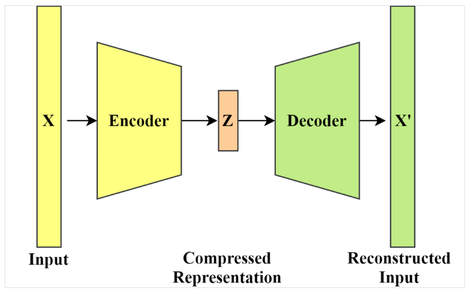

This notebook is based on the [Keras examples](https://keras.io/examples/), so have a look here for other computer vision problems.

## Setup and data processing steps

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers

Add some convenience functions for preprocessing and showing the images:

In [ ]:

def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


An important function for this experiment is one that **adds noise** to out images. This allows us to create a dataset where we know a noise-free version of each image (which we start out with), and a noisy version, which we created ourselves.

In [ ]:
def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

Load the MNIST dataset of handwritten digits.

In this case we throw away the labels for each image, which we don't need.

In [ ]:
(train_data, _), (test_data, _) = keras.datasets.mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)


## Build the model

Now for the exciting part: We want a model that can downsample and extract information, and then upsample it again to match the original dimensions of the image.

### <span style="color: red; font-weight: bold;">Exercise:<span>

Build a model that contains the following:

- Two sequential blocks that contain a convolutional layer followed by a max-pooling layer. Use 32 filters with kernel size 3x3, and `padding='same'`. The pooling layer can have pool size 2x2.
- A matching amount of `Conv2DTranspose` layers, that can upsample to the correct final dimensions. Try to find values of `kernel_size` and `strides` to achieve the correct output resolution. (Hint: look at the output shapes of the `MaxPooling` layers)
- The final layer should be a 1x1 convolution layer with sigmoid activation function.

In [ ]:
inputs = layers.Input(shape=(28, 28, 1))

# Your model definition goes here

autoencoder = keras.Model(inputs, outputs)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

## Train the model on unmodified images

First, let's test if the model can in fact compress the vital information in the images. Train it on the **noise-free** data, and then test if it can reconstruct images.

In [ ]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)


## Test the model

Now test the model (again on noise-free data) and see if the output is euqal to the input. If it is, we have shown that the image can effectively be compressed through a machine-learning approach.

In [ ]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

## Train on noisy data

Now for the actual task -- train the model to perform de-noising. We run the same training as before, but now with noisy inputs.

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

## The final test

Try out our denoising model:

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)